# Data Pipelines with TensorFlow

**Objectives:** In this session, we will discover how to:
- `Pipeline with Deep Learning`
- `Load a heavy dataset batch per batch`

# Part I: How to make `pipelines with Deep Learning`

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

## Load the `PetFinder` dataset

Let's load the **`PetFinder`** dataset. 
* Each row describes a pet, 
* Each column describes an attribute of a given pet.  

🎯 You will use this dataset and build a model to **predict whether the pet will be adopted or not**. 

In [2]:
dataframe = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/petfinder.csv")
dataframe

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11532,Dog,24,Poodle,Male,Brown,Golden,Medium,Medium,Not Sure,No,Healthy,0,0,0
11533,Cat,1,Domestic Short Hair,Female,Cream,Gray,Medium,Short,No,No,Healthy,0,1,1
11534,Dog,6,Schnauzer,Female,Black,White,Small,Long,Yes,No,Healthy,0,1,1
11535,Cat,9,Domestic Short Hair,Female,Yellow,White,Small,Short,Yes,Yes,Healthy,0,3,0


## Train-Val-Test Split

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


In [4]:
X_train = train.drop(columns='target')
y_train = train['target']

X_val = val.drop(columns='target')
y_val = val['target']

X_test = test.drop(columns='target')
y_test = test['target']

## Data Preprocessing...

In [5]:
X_train.dtypes

Type            object
Age              int64
Breed1          object
Gender          object
Color1          object
Color2          object
MaturitySize    object
FurLength       object
Vaccinated      object
Sterilized      object
Health          object
Fee              int64
PhotoAmt         int64
dtype: object

☝️ Our dataset has both Numerical and Categorical values. 

We need to preprocess all of these features before feeding our Neural Network.

You have three options:

**A**. Use SkLearn to preprocess data before feeding a neural network (`no pipelines`) 

**B**. Wrap your neural network into a Sklearn estimator (`SkLearn pipelines`)  

**C**. Use full `Tensorflow pipelines`

## A - Use SkLearn to preprocess the data before feeding a neural network (`no pipelines`)

### Preprocessing
❓ Create a `X_train_preproc`, `X_val_preproc`, `X_test_preproc` ❓
* Scaling Numerical Data
* One-Hot-Encoding Categorical Data

In [6]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector

In [7]:
preproc = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_exclude=["object"])),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), make_column_selector(dtype_include=["object"]))
)

In [8]:
preproc.fit_transform(X_train).shape

(7383, 180)

In [9]:
X_train_preproc = preproc.fit_transform(X_train)
X_val_preproc = preproc.transform(X_val)
X_test_preproc = preproc.transform(X_test)

### Neural Network

❓ Questions ❓
* `fit` a Neural Network
* and `evaluate` its performance on the test set 

In [10]:
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping

In [11]:
model = models.Sequential()

# Architecture
model.add(layers.Dense(32, activation='relu', input_shape=(X_train_preproc.shape[-1],)))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1, activation='sigmoid'))

# Model Compilation
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                5792      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                495       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 6,303
Trainable params: 6,303
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Defining the Early Stopping conditions
es = EarlyStopping(monitor = 'val_accuracy', # controlling the early stopping by the accuracy on the validation set
                   patience = 5,
                   verbose = 0,
                   restore_best_weights = True)

# Training the model with the preprocessed train and validation sets
history = model.fit(X_train_preproc,
                    y_train,
                    validation_data=(X_val_preproc, y_val),
                    batch_size=64,
                    epochs=500,
                    callbacks=[es],
                    verbose=0)

In [14]:
res = model.evaluate(X_test_preproc, y_test, verbose = 0)
print(f"test loss = {round(res[0],2)}")
print(f"test accuracy = {round(res[1],2)}")

test loss = 0.5
test accuracy = 0.76


## B - Wrap your neural network into a SkLearn estimator & pipelines

🚀 We can actually treat a Tensorflow.Keras model as a SciKit-Learn estimator, using the [Keras Wrappers](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn) !


👉 It allows us to:
* disguise a Deep Learning estimator built with Tensorflow as a SkLearn model
* and consequently:
    * place the estimator within a SkLearn pipeline 
    * include the preprocessing steps in this pipeline
    * and we can even:
        * `cross_validate`
        * `GridSearchCV` and `RandomizedSearchCV` the hyperparameters (but have fun defining the `param_grid` though...)

❓Run the two cells down below 👇 and try to understand the syntax ❓

In [15]:
from tensorflow.keras import Sequential
def create_model():
    
    # Define architecture without the input_shape yet
    # as we don't know the shape post preprocessing
    # Consequently, you cannot print the summary of a Dense Network without the input_shape
    # but the summary will be deduced after fittin the model on the X_train_preproc
    
    model = Sequential()
    
    ## First hidden Dense Layer + followed up with a Dropout Layer
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    
    
    ## Second hidden Dense Layer + followed up with a Dropout Layer
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    ## Binary Classification Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [16]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn = create_model, 
                        epochs = 10, 
                        batch_size = 32, 
                        verbose = 0)

### CrossValidating a NeuralNetwork

❓ Cross-validate your Deep Learning estimator on your training set (already preprocessed) ❓ 

In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
%%time 
cross_val_score(model,
                X_train_preproc,
                y_train,
                cv = 5,
                n_jobs=-1)

CPU times: user 80 ms, sys: 140 ms, total: 220 ms
Wall time: 25 s


array([0.74610698, 0.75423157, 0.74610698, 0.76151764, 0.74593496])

### Inserting a NeuralNet into a SkLearn Pipeline

❓ Questions ❓

* Wrap your model inside a pipeline including the preprocessing
* And evaluate the pipelined neuralnet directly on the raw data this time 

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn import set_config; set_config(display='diagram')

In [20]:
pipelined_neural_net = make_pipeline(preproc, model)
pipelined_neural_net

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe268524f70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe268524e20>)])),
                ('kerasclassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe24d3836a0>)])

In [21]:
%%time

pipelined_neural_net_scores = cross_val_score(pipelined_neural_net,  # Hooray ! 
                                              X_train,               # We are cross-validating
                                              y_train,               # a Deep Learning model
                                              cv = 5)                # that lives within a Pipeline

pipelined_neural_net_scores

CPU times: user 17.6 s, sys: 2.56 s, total: 20.1 s
Wall time: 13.1 s


array([0.74475288, 0.75490862, 0.74407583, 0.76693767, 0.74525744])

### GridSearchCV on the pipelined NeuralNet !

🔥 Now that our model is pipelined, we can even `GridSearchCV` its hyperparameters

❓ Run the cells down below 👇 to understand how the syntax works.

In [22]:
def create_model_grid(activation = 'relu', 
                      optimizer='rmsprop',
                     neurons_layer_1=32,
                     neurons_layer_2 = 32):
    
    # Create model
    model = Sequential()
    model.add(layers.Dense(units=neurons_layer_1, activation = activation)) # by default, we have set the activation to be the ReLU
    model.add(layers.Dropout(0.5))                       # but we will GridSearch over different activations
    model.add(layers.Dense(units=neurons_layer_2, activation = activation))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',     # by default, we have set the optimizer to be the RMSProp
                  optimizer = optimizer,          # but we will GridSearch over different optimizers
                  metrics=['accuracy'])
    
    return model

In [23]:
model_grid = KerasClassifier(build_fn = create_model_grid,
                             epochs = 10,
                             batch_size = 32,
                             verbose = 0)

model_grid

In [24]:
pipe_grid = make_pipeline(preproc, model_grid)
pipe_grid

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe268524f70>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe268524e20>)])),
                ('kerasclassifier',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe24dcf26a0>)])

In [25]:
# List of grid-searchable hyperparameters
list(pipe_grid.get_params().keys())

['memory',
 'steps',
 'verbose',
 'columntransformer',
 'kerasclassifier',
 'columntransformer__n_jobs',
 'columntransformer__remainder',
 'columntransformer__sparse_threshold',
 'columntransformer__transformer_weights',
 'columntransformer__transformers',
 'columntransformer__verbose',
 'columntransformer__verbose_feature_names_out',
 'columntransformer__standardscaler',
 'columntransformer__onehotencoder',
 'columntransformer__standardscaler__copy',
 'columntransformer__standardscaler__with_mean',
 'columntransformer__standardscaler__with_std',
 'columntransformer__onehotencoder__categories',
 'columntransformer__onehotencoder__drop',
 'columntransformer__onehotencoder__dtype',
 'columntransformer__onehotencoder__handle_unknown',
 'columntransformer__onehotencoder__sparse',
 'kerasclassifier__epochs',
 'kerasclassifier__batch_size',
 'kerasclassifier__verbose',
 'kerasclassifier__build_fn']

In [26]:
# There are also other grid-searchable parameters in the Training
pipe_grid.get_params()['kerasclassifier'].get_params()

{'epochs': 10,
 'batch_size': 32,
 'verbose': 0,
 'build_fn': <function __main__.create_model_grid(activation='relu', optimizer='rmsprop', neurons_layer_1=32, neurons_layer_2=32)>}

In [27]:
# By default, since the Pipeline includes a scaler, all the numerical values will be scaled
# but we can try with and without scaling just for the "fun" of GridSearching
pipe_grid.get_params()['columntransformer__standardscaler__with_mean'] 

True

In [28]:
# By default, activation = relu and optimizer = rmsprop
# but we can try to gridsearch them
pipe_grid.get_params()['kerasclassifier'].get_params()['build_fn']

<function __main__.create_model_grid(activation='relu', optimizer='rmsprop', neurons_layer_1=32, neurons_layer_2=32)>

In [29]:
# Now, we can Gridsearch the hyper-params of everything
# from the preprocessing, the architecture, the compiler... and the fit!

from sklearn.model_selection import GridSearchCV

param_grid = dict(
    columntransformer__standardscaler__with_mean=[True, False], # Preprocessing hyperparams
    kerasclassifier__activation=['tanh', 'relu'],       
    kerasclassifier__neurons_layer_1=[32, 64],                   
    kerasclassifier__neurons_layer_2=[32, 64],
    kerasclassifier__optimizer=["adam", "rmsprop"],             # Compiler hyperparams
    kerasclassifier__batch_size=[8, 64]                         # Fit hyperparams
)

grid = GridSearchCV(estimator=pipe_grid,
                    param_grid=param_grid,
                    cv=2,
                    verbose=2,
                    n_jobs=-1)

In [30]:
#it is going to take a loooong time! don't execute this cell, this is just an example of an advanced grid search with sklearn utils
#grid.fit(X_train, y_train);

Fitting 2 folds for each of 64 candidates, totalling 128 fits


In [31]:
#grid.best_params_

{'columntransformer__standardscaler__with_mean': False,
 'kerasclassifier__activation': 'relu',
 'kerasclassifier__batch_size': 8,
 'kerasclassifier__neurons_layer_1': 32,
 'kerasclassifier__neurons_layer_2': 64,
 'kerasclassifier__optimizer': 'adam'}

In [32]:
#grid.best_score_

0.750779390335083

## C - Full  `Tensorflow Pipeline` 

This option is recommended for real projects, especially when you need:
1. **`Performance`** and/or
2. **`Production-readiness`**


<details>
    <summary>▸ Why?</summary>

Indeed, having all preprocessing inside one single TensorFlow Keras model allows to generate one [`tf.Graph`](https://www.tensorflow.org/guide/intro_to_graphs) representation of your model, which is mandatory for distributed computation and serving on many devices (using Tensorflow Lite for back-end-free predictions for instance). 
</details>

🧠 The idea is to use **BatchNormalization** and **CategoryEncoding** layers within your model architecture.

| | SkLearn        | Tensorflow.Keras   |
|:--------------------|:----------------|:--------------------|
| **Scaling**            | StandardScaler | BatchNormalization |
| **Encoding**           | OneHotEncoder  | CategoryEncoding   |

### 😌 When the preprocessing pipeline is Sequential, easy peazy

Imagine that we had only numerical data. 

In this case, we could use the previous section to create a Pipeline with:
* the Standard Scaler
* and a `"SkLearn-Wrapped" KerasClassifier` 

as follows: 👇

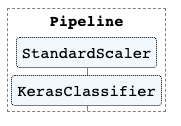

In [34]:
# Imagine we are dealing only with Numerical data to scale
X_train_num = X_train.select_dtypes(exclude=['object']).values
X_val_num = X_val.select_dtypes(exclude=['object']).values
X_test_num = X_test.select_dtypes(exclude=['object']).values

😅 But the procedure of:

1. Wrapping up a Deep Learning model into a SkLearn estimator
2. Incorporating the wrapped model into a Pipeline

can be tedious.

🚀🚀🚀 Actually, we could directly add a `Normalization` layer to our NeuralNet Classifier ! 🚀🚀🚀

In [35]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization

######################################
#        NormalizationLayer          #
######################################

normalizer = Normalization()    # Instantiate a "Normalization" Layer
normalizer.adapt(X_train_num)   # "Fit" it on the train set


######################################
#  Architecture of the NeuralNetwork #
######################################

model = models.Sequential()

# Use the fitted Normalization layer as the first sequential step
model.add(normalizer)                          

# Add the classic combos Dense Layer + Dropout Layer
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dropout(0.3))

# Prediction Layer a.k.a Classification Layer
model.add(layers.Dense(1, activation='sigmoid'))

######################################
#  Compilation of the NeuralNetwork  #
######################################

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

######################################
#     Training the NeuralNetwork     #
######################################

history = model.fit(X_train_num,
                    y_train,
                    validation_data=(X_val_num, y_val),
                    batch_size = 64,
                    epochs = 20, 
                    verbose = 0)

######################################
#    Evaluating the NeuralNetwork    #
######################################

res = model.evaluate(X_test_num, y_test, verbose = 0)

print(f"test loss = {round(res[0],2)}")
print(f"test accuracy = {round(res[1],2)}")

test loss = 0.53
test accuracy = 0.74


### 🤯 What if the preprocessing pipeline requires parallel column transformers ? `TensorFlow Sequential API`  is not enough...

You cannot add a `Normalization` layer followed sequentially by a `CategoryEncoding` layer or the other way around, it simply does not make sense as:
* the first transformation is applied to numerical data and the second one is applied to categorical data
* the two transformations are done in parallel

🎯 Technically, we want to replicate the following workklow from SkLearn 👇 but the Tensorflow.Keras way!

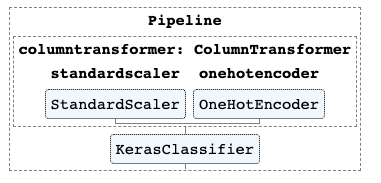

🧨 You will need to use the **`TensorFlow Fonctional API`** to produce a **`Non-Sequential Neural Network`**


> _"Oh my god... Sequential Networks are already a hot topic, how am I going to be able to learn about these Non Sequential Networks ? 😱"_

📚 Google got your back ! Follow the [Google Tensorflow Tutorials - Structured Data - Preprocessing Layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) 

👩🏻‍💻 In practice, coding non-sequential models look like this: 👇

```python
# Numerical preprocessing model = function(X_numerical)
model_numerical = ...  

# Categorical preprocessing model = function(X_categorical)
model_categorical = ...

# Combined model
all_features = layers.concatenate([model_numerical, model_categorical])

# Then create the Dense network on the preprocessed features
x = tf.keras.layers.Dense(8, activation="relu")(all_features)
x = tf.keras.layers.Dense(2, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)

model.compile(...)
```

<img src='https://github.com/lewagon/data-images/blob/master/DL/non_sequential_models.png?raw=true' width=400>

🎉 During the last recap of the Deep Learning module, we will concatenate the outputs of multiple NeuralNets into a single NeuralNet !

🔥 Stay _TUNED_ !

---

# Part II. How to `deal with heavy datasets`?

⚠️ Most Deep Learning projects use datasets that are wayyy **too heavy to be loaded on the RAM of your computer entirely**  

💪 Fortunately, in Deep Learning models, we have to train/feed our network only  **batch per batch**!

✅ Tensorflow provides a powerful [`tf.data.Dataset`]() class that help to deal with data loading and processing batch-per-batch

✅ Keras provides cool [`tf.keras.preprocessing wrappers`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing) so that you avoid getting your hands too dirty:
- 🖼 `image_dataset_from_directory`
- 🗣 `text_dataset_from_directory`
- 📈 `timeseries_dataset_from_array`

---

Let's illustrate this with a heavy dataset containing images 👇

### 1 - Save large files on a hard drive (local or cloud)

❓ Run following cells (never mind the syntax)

In [36]:
! pip install -U --quiet tensorflow_datasets Pillow

In [37]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt

In [38]:
# We download 229Mo of images

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin = dataset_url, 
                                   fname = 'flower_photos', 
                                   untar = True)
data_dir = pathlib.Path(data_dir)

In [39]:
# We've just unzipped and saved all these file in the following folder 
data_dir

PosixPath('/Users/yannisbouhamou/.keras/datasets/flower_photos')

In [40]:
# Notice how each photo is saved in a different folder depending on its category
! ls $data_dir

LICENSE.txt daisy       dandelion   roses       sunflowers  tulips


In [41]:
# In total we have 229Mo of files, compressed.
# Imagine that we had in total 50Go of files ? They couldn't obviously fit in your RAM
! du -h $data_dir

 39M	/Users/yannisbouhamou/.keras/datasets/flower_photos/roses
 54M	/Users/yannisbouhamou/.keras/datasets/flower_photos/sunflowers
 34M	/Users/yannisbouhamou/.keras/datasets/flower_photos/daisy
 48M	/Users/yannisbouhamou/.keras/datasets/flower_photos/dandelion
 54M	/Users/yannisbouhamou/.keras/datasets/flower_photos/tulips
229M	/Users/yannisbouhamou/.keras/datasets/flower_photos


In [42]:
# We have 3670 jpg images in 5 classes
len(list(data_dir.glob('*/*.jpg')))

3670

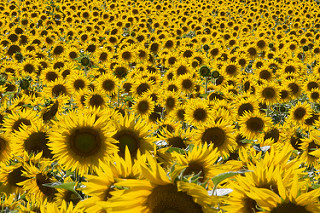

In [43]:
# Now, let's just have a look at one image
sunflowers = list(data_dir.glob('sunflowers/*'))
PIL.Image.open(str(sunflowers[0]))

### 2 - Prepare to load images in the RAM memory batch per batch 

👉 We will use **`image_dataset_from_directory`**

In [44]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [45]:
ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  batch_size=32)

Found 3670 files belonging to 5 classes.


☝️ Notice how it automatically labelled the images of our dataset into the 5 classes!
- By default, `labels='inferred'` from the folder structure
- You can pass a list of labels manually with a list of integers

In [46]:
# `ds` is a `tf.data.Dataset` object of "tuples"
ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [47]:
# The dataset objects `ds` contains absolutely no real data until it is iterated over 
import sys
sys.getsizeof(ds)

48

In [48]:
for (X_batch, y_batch)  in ds:
    print(X_batch.shape)
    print(y_batch.shape)
    
    break # Just show the shapes of the first element

(32, 256, 256, 3)
(32,)


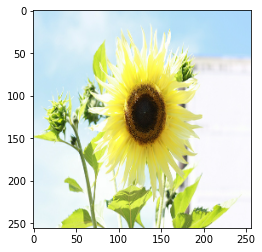

In [49]:
# Checking the first image
plt.imshow(X_batch[0]/255);

**`tf.data.Dataset`** are just abstractions that represent a sequence of elements. They allow to

- Load elements batch-per-batch in memory
- From different formats, storage places, etc...
- Apply preprocessing on the fly (ex: shuffle, resize, and many more...)

📚 [TF Guide on data](https://www.tensorflow.org/guide/data)

### 3 - Train a model directly on a `Dataset`

❓ Try to fit a simple Dense Neural Network on `ds`:

- You can directly call **`model.fit(ds, epochs=1)`**
- Your first layer should use** `layers.Flatten`** to flatten a (256 ,256 ,3) picture into a (256 $\times$ 256 $ \times$ 3, ) vector, hence acceptable for Dense Layers
- You can use `loss='sparse_categorical_crossentropy'` instead of the `categorical_cross_entropy`:
    - `"sparse_"` saves you the step of converting your target `y` to its categorical version `to_categorical(y)`


In [50]:
X_batch.shape

TensorShape([32, 256, 256, 3])

In [51]:
y_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 1, 4, 1, 4, 1, 1, 0, 3, 4, 0, 3, 3, 3, 2, 2, 3, 4, 3, 2, 1, 4,
       0, 3, 0, 3, 3, 2, 1, 1, 4, 4], dtype=int32)>

In [52]:
# Let's try a dummy model, just to prove that it can fit
model = models.Sequential()

# Flattening the picture  into 256 x 256 x 3 vector that can be passed to a Dense layer
model.add(layers.Flatten(input_shape=(256,256,3))) 

# Hidden Dense Layer
model.add(layers.Dense(16, activation='relu'))

# Multiclass Classification Layer
model.add(layers.Dense(5, activation='softmax'))

# Printing the summary of the model
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense_39 (Dense)             (None, 16)                3145744   
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 85        
Total params: 3,145,829
Trainable params: 3,145,829
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy', # "sparse_" allows to avoid one-hot-encoding the target
  metrics=['accuracy'])

model.fit(ds, epochs=1)

115/115 [==============================] - 12s 98ms/step - loss: 477.5344 - accuracy: 0.2245


🎲 If we were to randomly guess a class, the accuracy on this balanced dataset would be $ \frac{1}{5} = 20 $ %

🤔 What is the point of creating a Neural Network that barely beats the baseline ?

⚠️ Actually, a Dense Neural Network is not the best suited architecture for image classification.

---

🏁 **Congratulations** for this second module of Deep Learning! That was an intense session !


---

🚀 To **`deal with images`**, we will use a new type of layers called the `Convolutional Layers` and...

... we will build **`Convolutional Neural Networks`** ! 🚀


---

❗️ Come back to this Recap Session after studying CNN ❗️

## (Bonus) Proper solution to the Flowers' problem using CNN & Early Stopping

In [54]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(64, 64), # resize on the fly
    batch_size=32)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(64, 64), # resize on the fly
    batch_size=32)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [55]:
model = tf.keras.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1. / 255))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[EarlyStopping(patience=0)]
)

Epoch 1/5
92/92 [==============================] - 17s 173ms/step - loss: 1.3724 - accuracy: 0.4019 - val_loss: 1.1573 - val_accuracy: 0.5123
